In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numpy import linalg as LA
import imageio
import moviepy
import random
import time
from itertools import permutations
from collections import defaultdict
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from skimage import img_as_ubyte

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [2]:
def sig_func(x,y):
    return(1/(1+np.exp(-(np.dot(x,y)))))

In [3]:
def mutate(x,rate):
    chosen = np.random.choice(range(0,len(x)),rate,replace=False)
    for i in range(0,len(x)):
        if i in chosen:
            x[i] = 2*np.random.random(1)-1
    return(x)

In [4]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [5]:
def extract_tribe(cells, cell_weights, n, labels, node_n = 225):   
    db = AgglomerativeClustering(n).fit(cell_weights)
    print(db.labels_)
    flags = []
    for k in labels:
        flags = [flags, [j for j, x in enumerate(db.labels_ == k) if x]]
    flags = flags[1:]
    print(flags)
    next_cells = cells[flags,:]  
    next_weights = cell_weights[flags,:]
    return(next_cells[0], next_weights[0], db)

In [6]:
def slime(x = [],
          y = [],
          start_pop = 200,
          max_age = 100,
          fig_size = [5,5],
          board_size = 128,
          fertile = 6,
          start_hp = 4,
          log = False,
          frames=500,
          interval=50,
          mutation_rate = 40,
          willing_wait = 5,
          mode='once'):
    
    global sight
    global time_tick
    global grow_count
    global birth_count
    global bump_count
    global trends
    global cells
    global cell_weights
    global cell_name
    global killed
    global border
    global last_time
    global new_coord
    global G
    global for_gif
    global max_hp
    global frame_count
    
    total_start_time = time.time()
    frame_count = 1
    max_hp = fertile
    sight = 9
    G = nx.Graph()
    time_tick = 0
    trends = np.array([0,0,0,0,0,0])
    border = round(board_size/3)
    last_time = 0
    cell_name = 1
    new_coord = [[-1,1],
                 [0,1],
                 [1,1],
                 [-1,0],
                 [0,0],
                 [1,0],
                 [-1,-1],
                 [0,-1],
                 [1,-1]]
    
    # Build the initial cell list.  NN is built around sight/input of 5, movement/output of 3.
    if(len(x) < 1):
        cells = np.zeros((start_pop,5))
        cell_weights = np.zeros((start_pop,(sight*sight*3*3)))
        
        for cell in range(0,start_pop):
            cells[cell,:] = [cell_name,
                          np.random.choice(range(border, board_size-border)),
                          np.random.choice(range(border, board_size-border)),
                          start_hp,
                          1]
            cell_weights[cell,:] = 2*np.random.random((sight*sight*3*3))-1
            G.add_node(cell)
            cell_name += 1          
    else:
        cells = x
        cell_weights = y
        start_pop = len(cells)

    # Create the board.
    X = np.zeros(shape=(board_size,board_size))
    for_gif = X
    
    # initialization function: plot the background of each frame
    def init():
        im.set_data(X)
        return (im,)
    
    # Get the coodinates for the input.
    L = [0, 0, 1, 1, -1, -1, 2, 2, -2, -2, 3, 3, -3, -3, 4, 4, -4, -4]
    keep = [0,0]
    
    for comb in permutations(L, r=2):
        keep = np.vstack((keep, comb))
    
    # Setup plotting.
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(0, 8)
        
    def animate(i):
        global sight
        global time_tick
        global grow_count
        global birth_count
        global bump_count
        global trends
        global cells
        global cell_weights
        global cell_name
        global total_pop
        global killed
        global border
        global last_time
        global new_coord
        global G
        global for_gif
        global max_hp
        global frame_count
        
        # Saftey net for long runs.
        if(last_time > willing_wait):
            print("Taking too long...")
        
        start_time = time.time()
        grow_count = 0
        birth_count = 0
        bump_count = 0
        killed_this_round = np.array([], dtype = int)
        
        # Take turns through the cell list.
        time_tick += 1
        im.set_data(animate.X)
        
        for cell in range(0, len(cells)):
            
            # Input.
            test_in = []
            for perm in np.mod(cells[cell,1:3] + np.unique(keep,axis=0), board_size):
                test_in = np.append(test_in, X[int(perm[0]), int(perm[1])])

            # Output.
            test_out = sig_func(test_in,cell_weights[cell,:].reshape((sight*sight, 3*3)))
            d = test_out.tolist().index(np.random.choice([i for i in test_out if i <= (np.min(test_out)+np.random.rand()*np.max(test_out))]))
            #d = test_out.argmin()
            #print(test_out)
            #print(d)

            # Stay and Grow.
            if(d==4):
                if(cells[cell,3] < max_hp/2):
                    cells[cell,3] += 1
                    grow_count += 1
                    if(log == True):
                        print("{0} grew to size {1}.".format(cells[cell,0], cells[cell,3]))

                # Handle birth/splitting, don't clear.
                if(cells[cell,3] >= max_hp):
                    
                    # Get the coodinates for possible baby locations.
                    L = [0, 0, 1, 1, -1, -1]
                    keep2 = [0,0]

                    for comb in permutations(L, r=2):
                        keep2 = np.vstack((keep2, comb))

                    potential = []
                    for perm in np.mod(cells[cell,1:3] + np.unique(keep2,axis=0), board_size):
                        potential = np.append(potential, X[int(perm[0]), int(perm[1])])
                        
                    clear = []
                    for i in potential:
                        if(i == 0):
                            clear = np.append(clear,i)

                    if(len(clear) > 0):
                        d = np.random.choice(range(0,len(clear)))
                        # Give new coordinate and fill it in.
                        destination = np.mod(np.add(cells[int(cell),1:3], new_coord[d]), board_size)
                        
                        # Half parent hp.
                        divided_hp = np.floor(cells[cell,3]/2)
                        cells[cell,3] = divided_hp

                        # Give the baby attributes and mutate the NN.
                        baby_name = cell_name
                        G.add_node(baby_name)
                        G.add_edge(cell_name, baby_name)
                        cell_name += 1

                        a = [baby_name,
                             int(destination[0]),
                             int(destination[1]),
                             divided_hp,
                             1]
                        b = mutate(cell_weights[cell,:], mutation_rate)
                        cells = np.vstack((cells, a)) 
                        cell_weights = np.vstack((cell_weights, b))
                        X[int(destination[0]), int(destination[1])] = abs(sum(b))

                        birth_count += 1
                        if(log == True):
                            print("{0} underwent mitosis.  Gave birth to {1}.".format(cells[cell,0], baby_name))

            # Move.
            else:
                # If it is clear to move.
                destination = np.mod(np.add(cells[cell,1:3], new_coord[d]), board_size)
                
                if(X[int(destination[0]), int(destination[1])] == 0):
                    # Clear where it was if not splitting.
                    last_spot = cells[cell,1:3]
                    X[int(last_spot[0]),int(last_spot[1])] = 0         
                    # Give new coordinate and fill it in.
                    cells[cell,1:3] = destination
                    X[int(destination[0]), int(destination[1])] = abs(sum(cell_weights[cell,:]))
                    
                else:
                    # It gets bumped.    
                    x = [i for i, j in enumerate(cells[:,1]) if j == destination[0]]
                    y = [i for i, j in enumerate(cells[:,2]) if j == destination[1]]
                    z = intersection(x,y)
                    
                    if(len(z) == 1):
                        rat = np.log(cells[z,4]/cells[cell,4])/np.e
                        if(cells[cell,3] > cells[z,3]):
                            cells[cell,3] += np.round(3+rat)
                            cells[z,3] -= np.round(3+rat)
                        if(cells[cell,3] == cells[z,3]):
                            cells[cell,3] += np.round(1+rat)
                            cells[z,3] -= np.round(1+rat)
                        if(cells[cell,3] < cells[z,3]):
                            cells[cell,3] -= np.round(2-rat)
                            cells[z,3] += np.round(2-rat)  
                        bump_count += 1
                        if(log == True):
                            print("{0} was injured to size {1}!".format(cells[cell,0], cells[cell,3]))
                            
                        try:
                            # Handle death.
                            if(cells[cell,3] < 1):
                                # Clear where it was and delete from list.
                                last_spot = cells[cell,1:3]
                                X[int(last_spot[0]),int(last_spot[1])] = 0
                                killed_this_round = np.append(killed_this_round,int(cells[cell,0]))
                                if(log == True):
                                    print("{0} died!.".format(cells[cell,0]))

                            if(cells[z,3] < 1):
                                # Clear where it was and delete from list.
                                last_spot = cells[z,1:3]
                                X[int(last_spot[0]),int(last_spot[1])] = 0
                                killed_this_round = np.append(killed_this_round,int(cells[z,0]))
                                if(log == True):
                                    print("{0} died!.".format(cells[z,0]))
                        except:
                            pass
        
        # Kill the elderly        
        for i in range(0,len(cells)):
            if(cells[int(i),4] > max_age):
                # Blur max age a bit
                if(np.random.random() < (cells[int(i),4]-max_age)/max_age):      
                    # Clear where it was and delete from list.
                    last_spot = cells[cell,1:3]
                    X[int(last_spot[0]),int(last_spot[1])] = 0
                    killed_this_round = np.append(killed_this_round,int(cells[cell,0]))
                    if(log == True):
                        print("{0} died of old age!.".format(cells[cell,0]))
                    
        for i in np.unique(killed_this_round):
            j = list(cells[:,0]).index((i))
            cells = np.delete(cells, (j), axis=0)
            cell_weights = np.delete(cell_weights, (j), axis=0)
        
        run_pop = len(cells)   
        if(np.random.random() < -np.log(run_pop/(start_pop)/np.e)):
            if(max_hp > 3):
                    max_hp -= 1
                    print("We're going extinct, make babies!  Breeding requirements decreased to {0}.".format(max_hp))

        if(np.random.random() < np.log(run_pop/(start_pop)/np.e)):
                max_hp += 1
                print("Too crowded, stop having kids!  Breeding requirements increased to {0}.".format(max_hp))
        
        cells[:,4] = np.add(cells[:,4],1)
        for_gif = np.concatenate((for_gif, X))
        death_count = len(np.unique(killed_this_round))
        current = np.array([time_tick, grow_count, birth_count, bump_count, death_count, run_pop])                
        trends = np.vstack((trends, current))
        last_time = time.time() - start_time
        
        if(np.mod(frame_count,10) == 0):
            print("Frame {0} took {1} seconds.".format(frame_count,round(last_time,1)))
        frame_count += 1
    
        return (im,)
        
    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval, blit=True)
    html_result = display_animation(anim, default_mode=mode)
    
    # Make a little gif
    images = []
    #normalized = for_gif/(LA.norm(for_gif,axis=0)) 
    for i in range(0,(frames+1)):
        #converted = np.reshape(normalized,((frames+1),board_size,board_size))[int(i),:,:]
        #converted = img_as_ubyte(converted)
        converted = np.reshape(for_gif,(len(trends),board_size,board_size))[int(i),:,:]
        imageio.imwrite('slime.gif', converted)
        images.append(imageio.imread('slime.gif'))
    imageio.mimsave('slime.gif', images)
    
    total_last_time = time.time() - total_start_time
    print("Total Run Time:  {0} seconds.".format(round(total_last_time,1)))
    
    return (html_result, cells, cell_weights, G, trends[1:,:], for_gif)

In [7]:
gr, c, cw, g, t, a = slime(start_pop=200, board_size=128, frames=100)

We're going extinct, make babies!  Breeding requirements decreased to 5.
We're going extinct, make babies!  Breeding requirements decreased to 4.
We're going extinct, make babies!  Breeding requirements decreased to 3.
Frame 10 took 0.4 seconds.
Frame 20 took 0.5 seconds.
Frame 30 took 0.6 seconds.
Frame 40 took 0.9 seconds.
Frame 50 took 0.7 seconds.
Frame 60 took 0.9 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 4.
Frame 70 took 1.1 seconds.
Frame 80 took 1.2 seconds.
Frame 90 took 1.4 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 5.
Too crowded, stop having kids!  Breeding requirements increased to 6.
Too crowded, stop having kids!  Breeding requirements increased to 7.


Frame 100 took 1.4 seconds.


Total Run Time:  93.0 seconds.



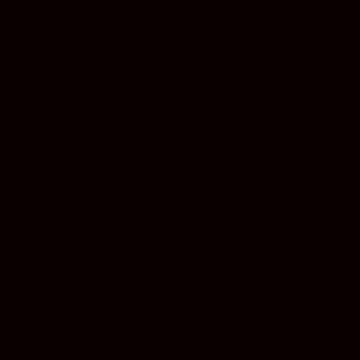
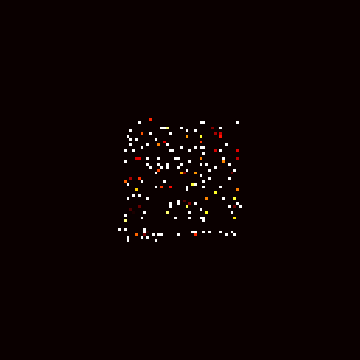
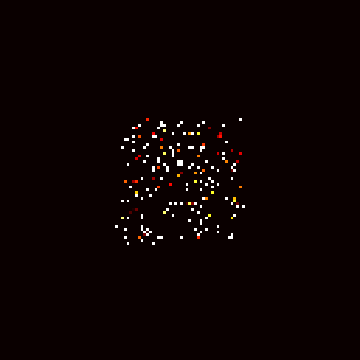
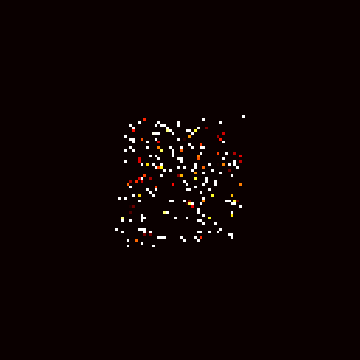
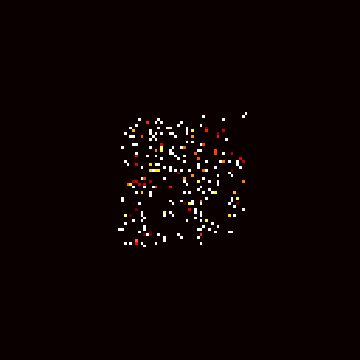
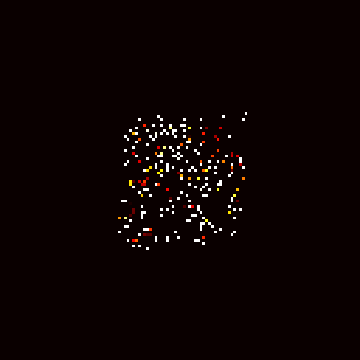
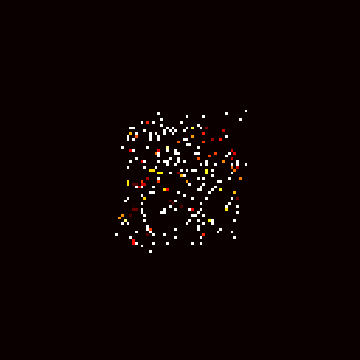
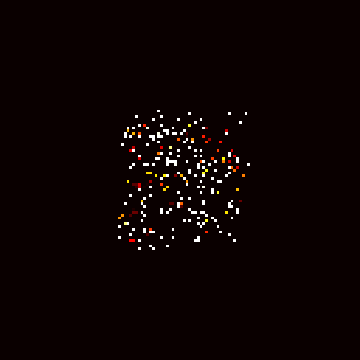
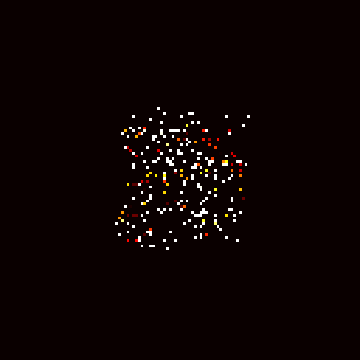
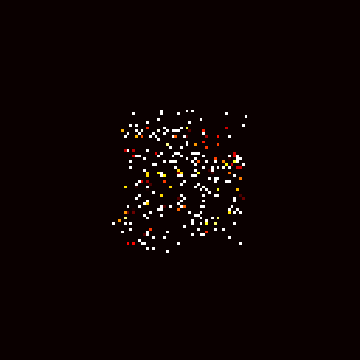
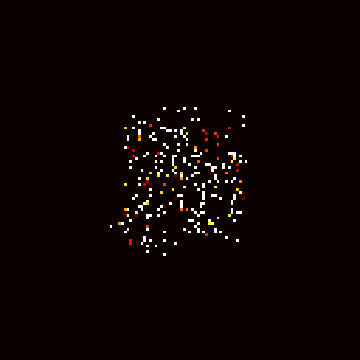
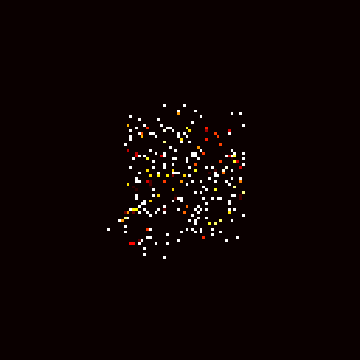
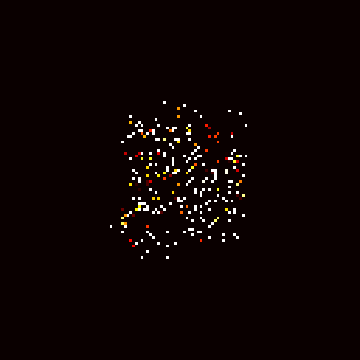
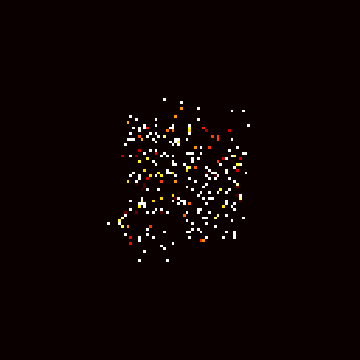
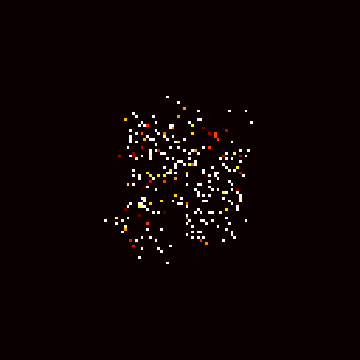
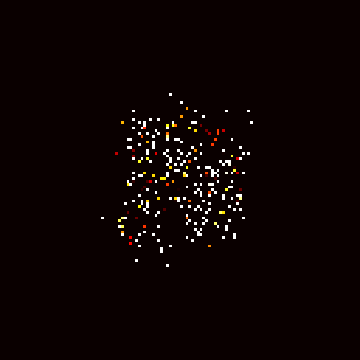
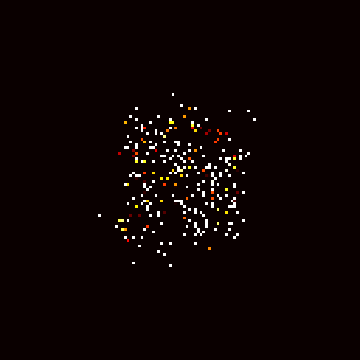
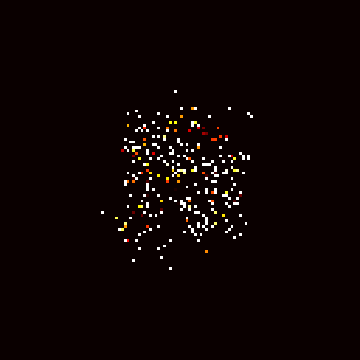
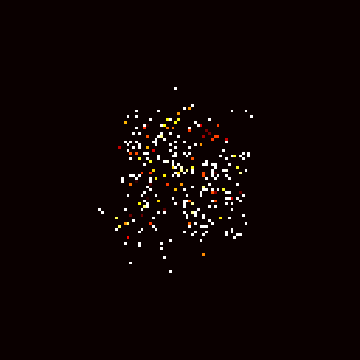
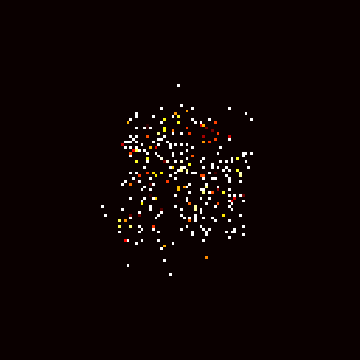
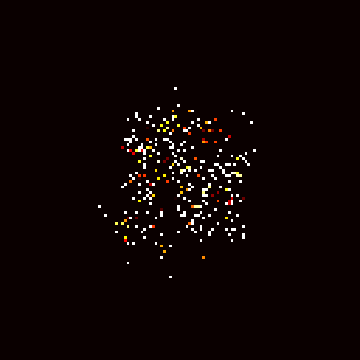
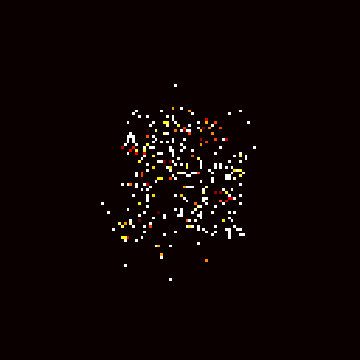
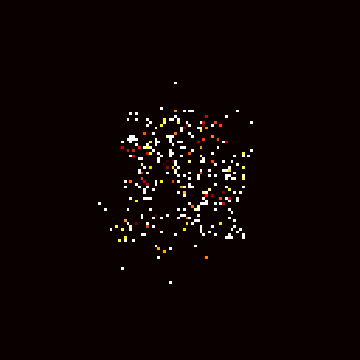
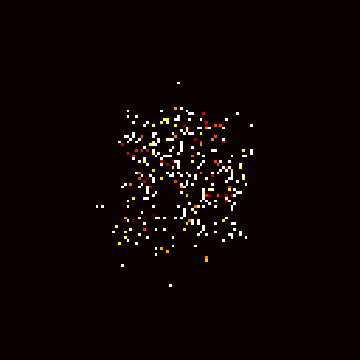
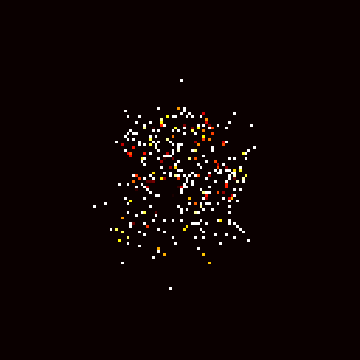
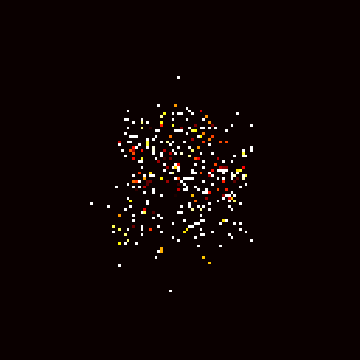
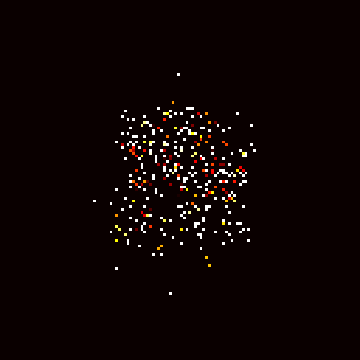
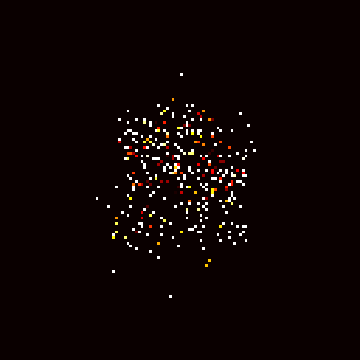
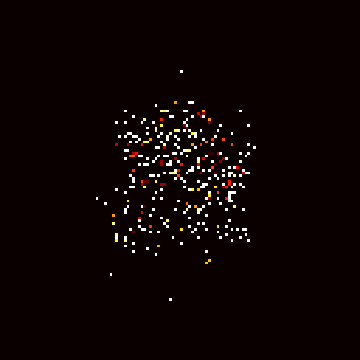
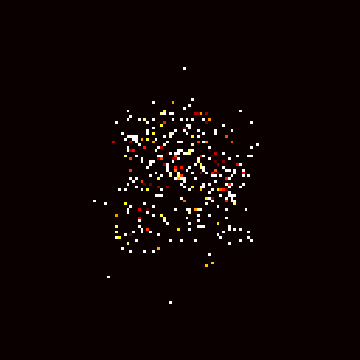
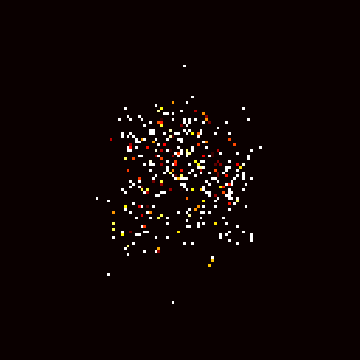
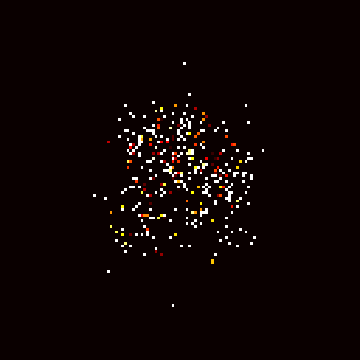
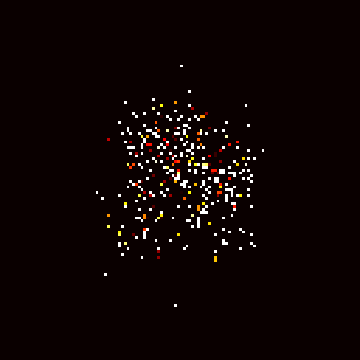
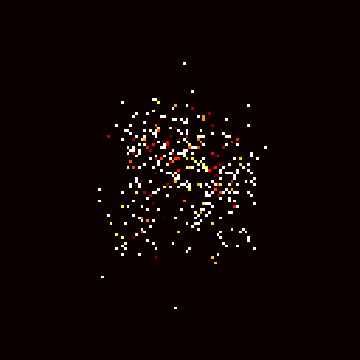
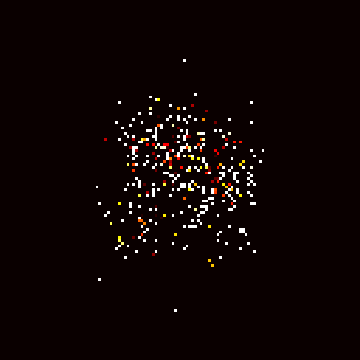
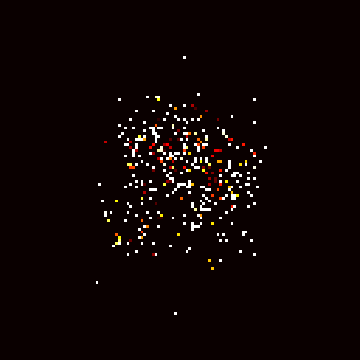
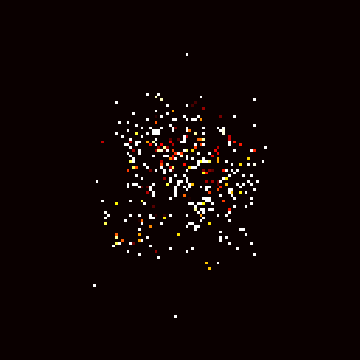
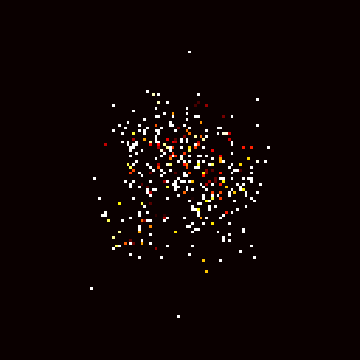
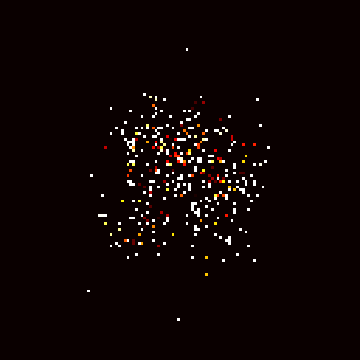
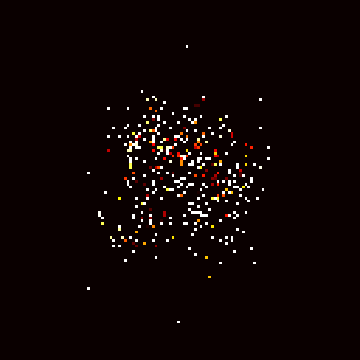
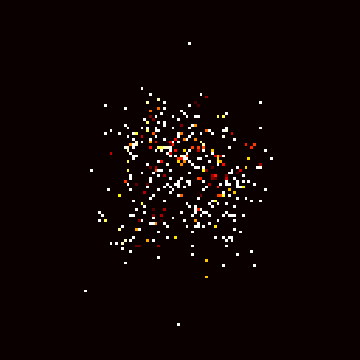
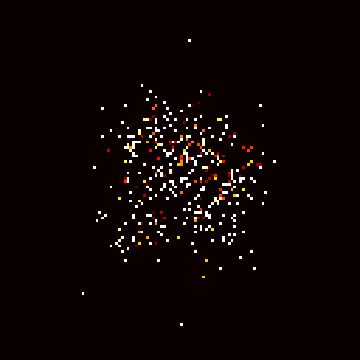
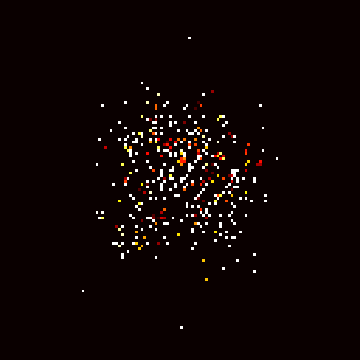
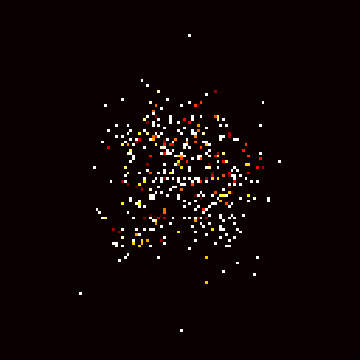
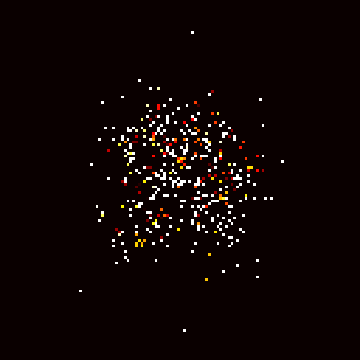
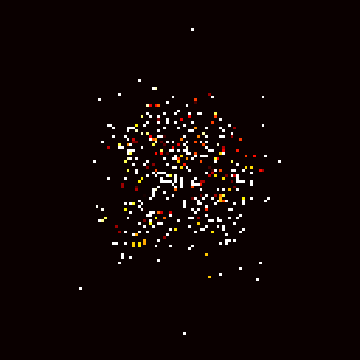
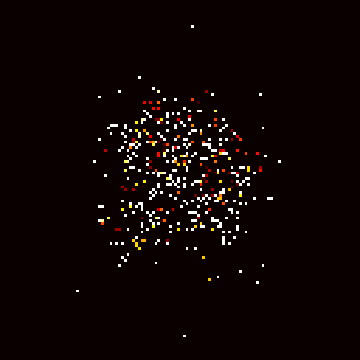
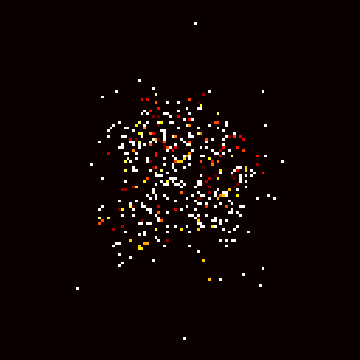
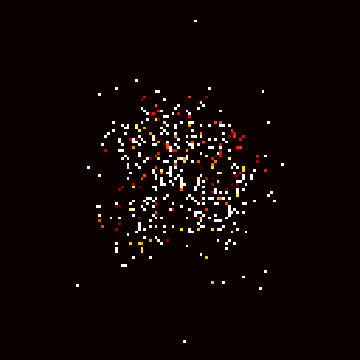
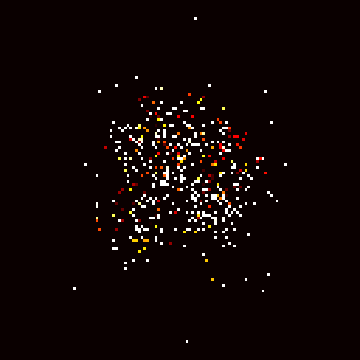
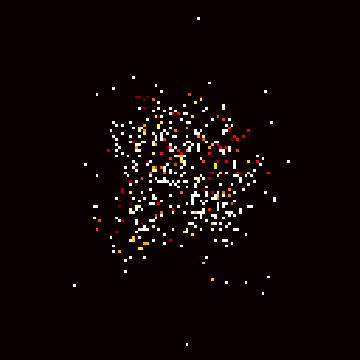
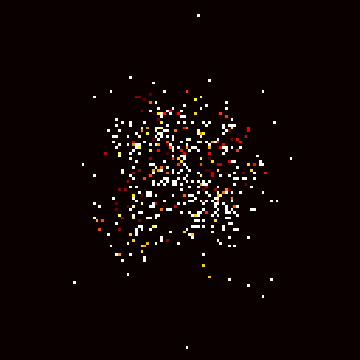
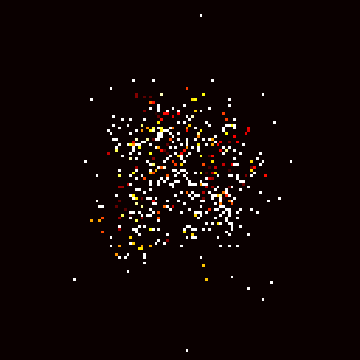
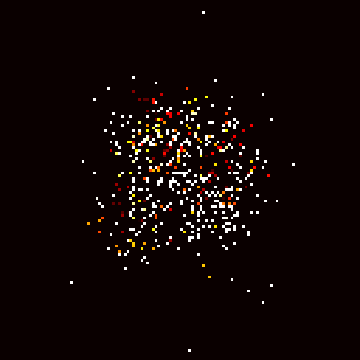
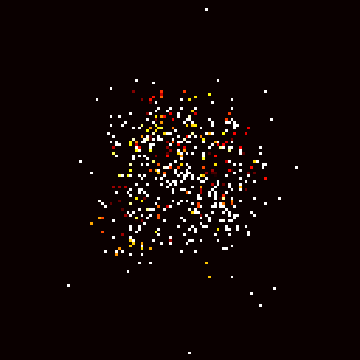
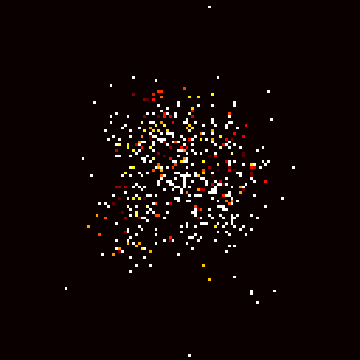
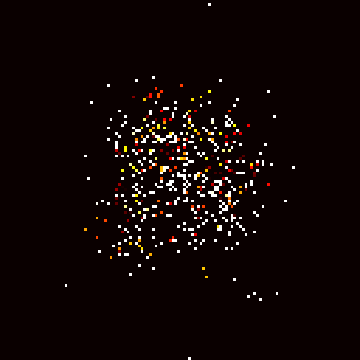
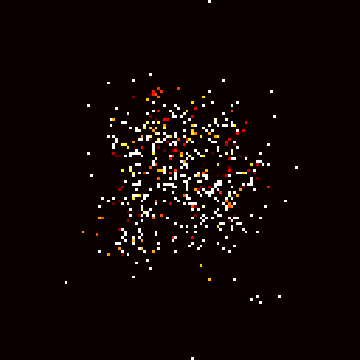
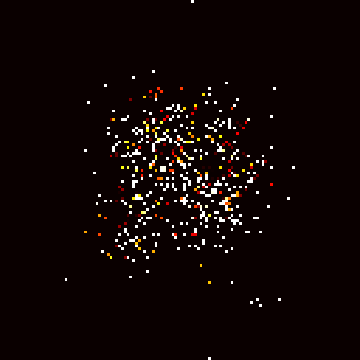
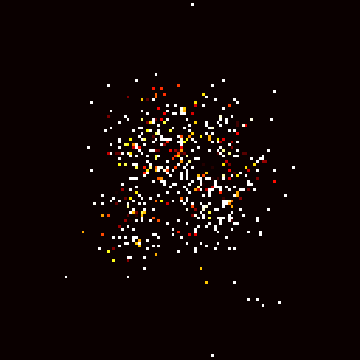
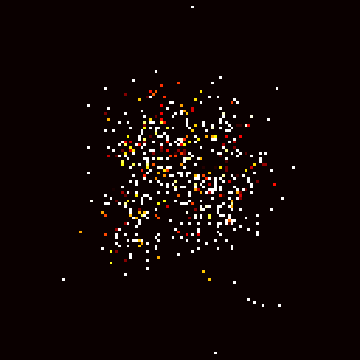
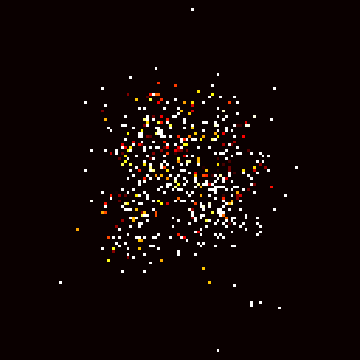
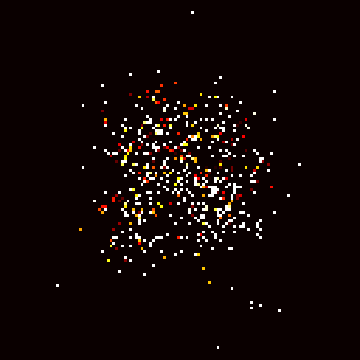
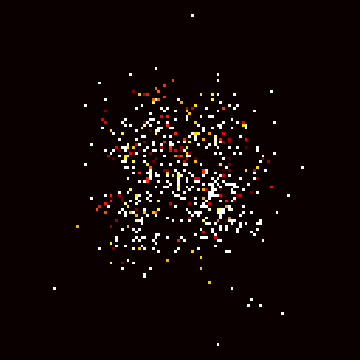
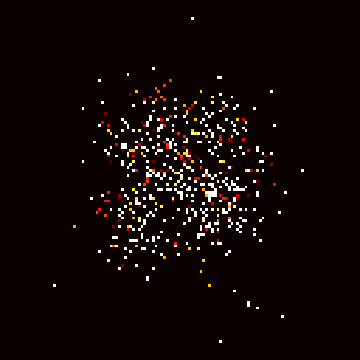
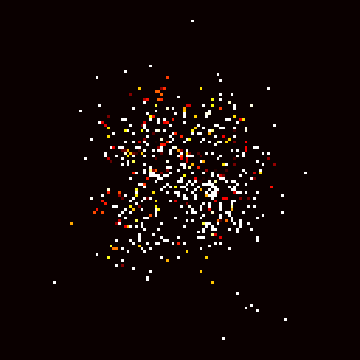
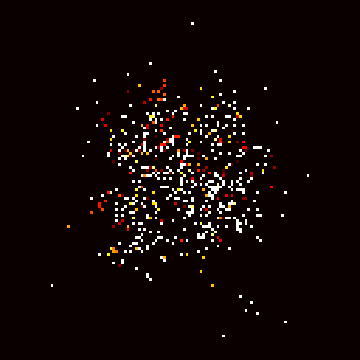
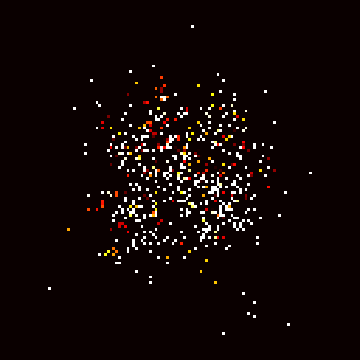
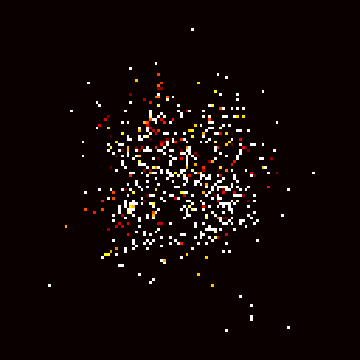
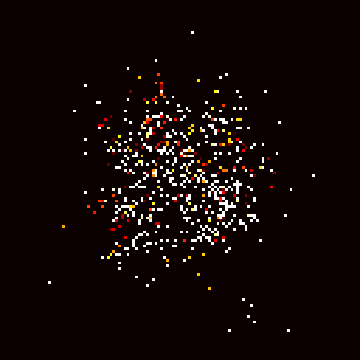
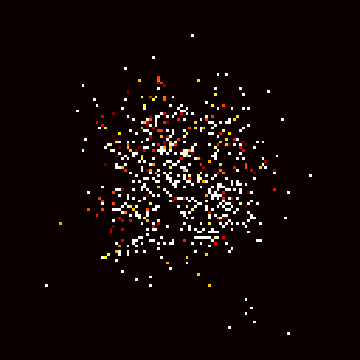
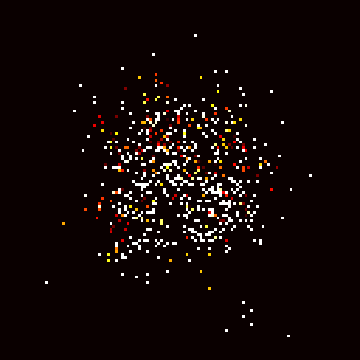
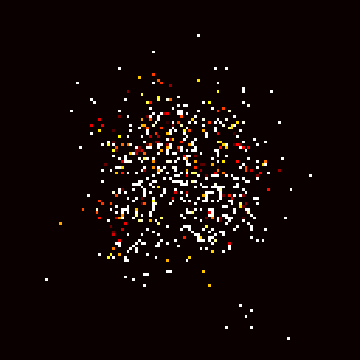
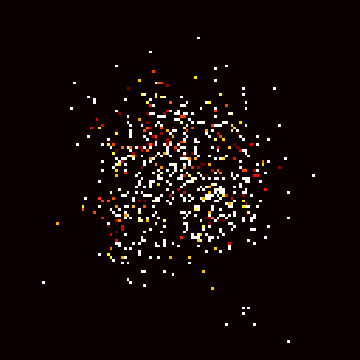
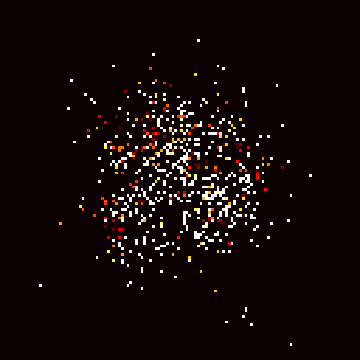
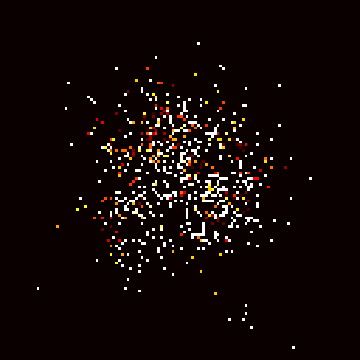
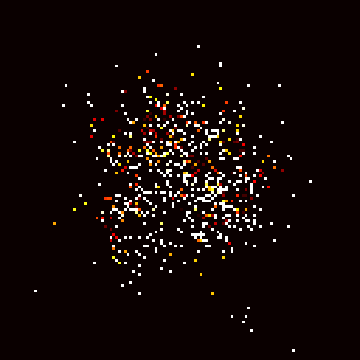
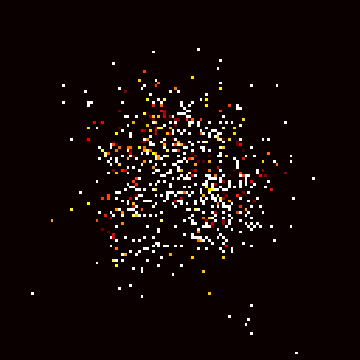
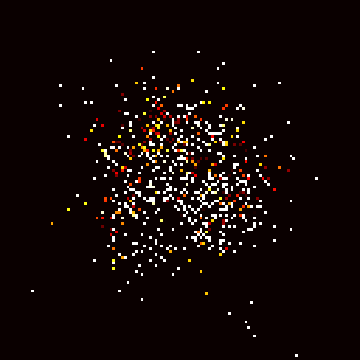
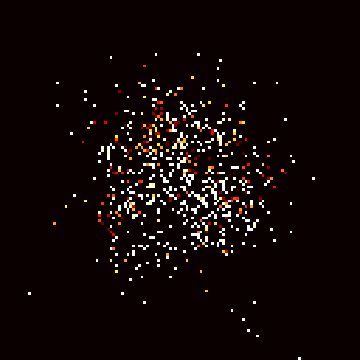
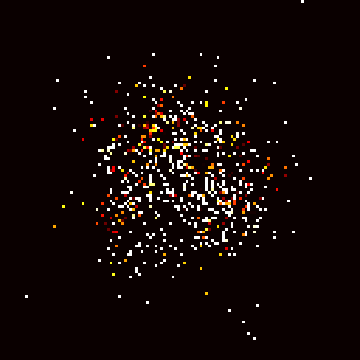
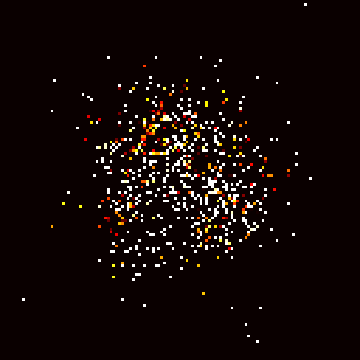
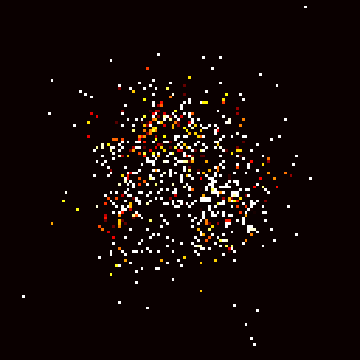
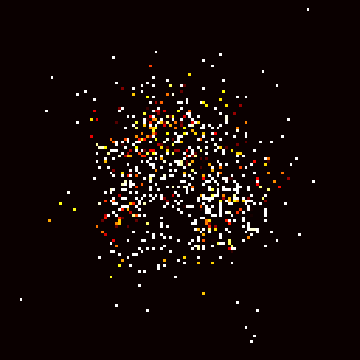
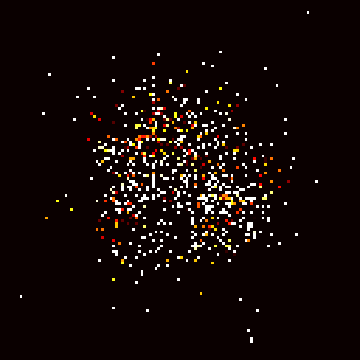
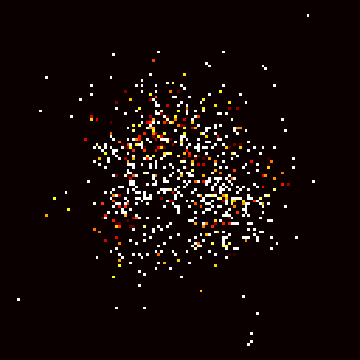
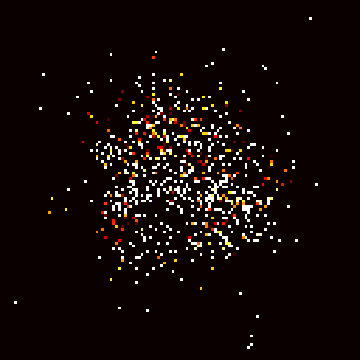
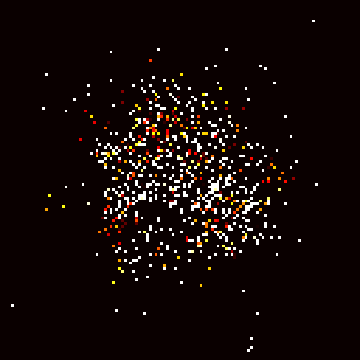
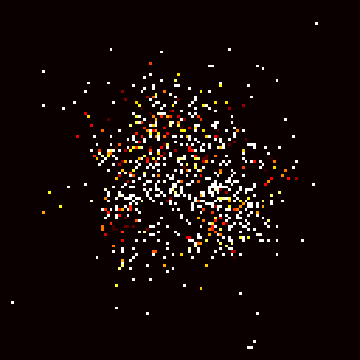
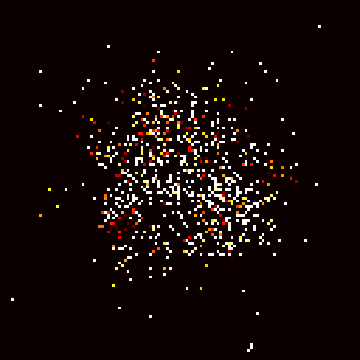
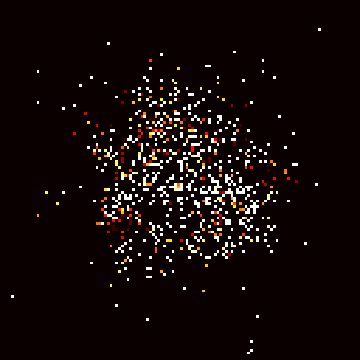
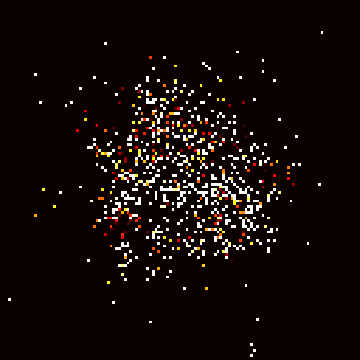
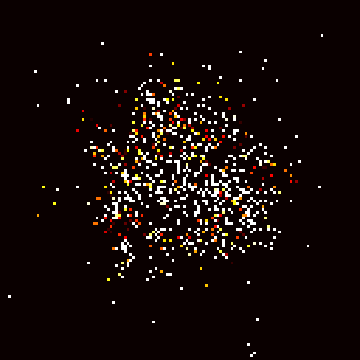
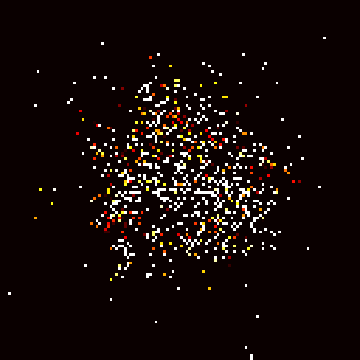
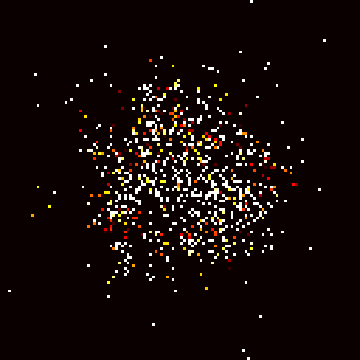
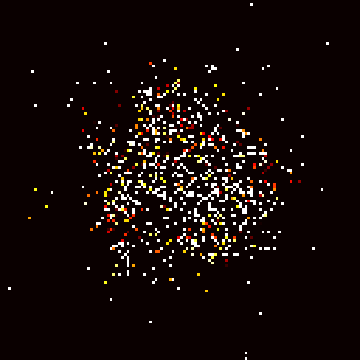
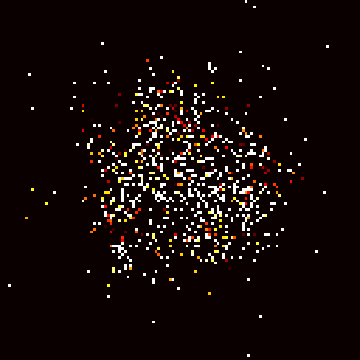
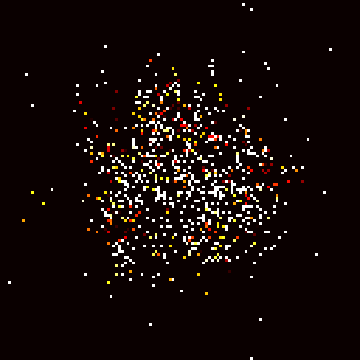
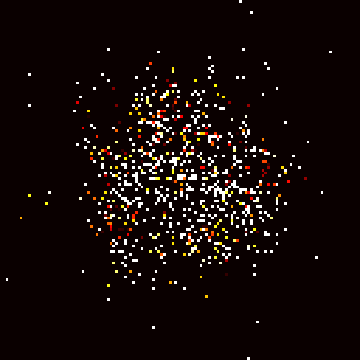
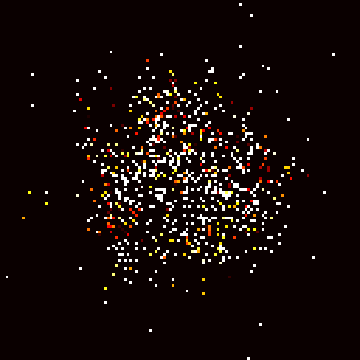

In [8]:
gr

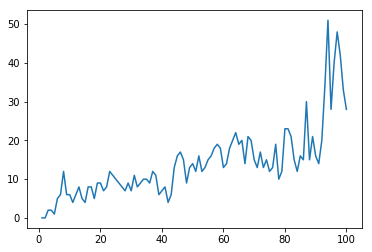

In [9]:
# Growth
plt.plot(t[:,0],t[:,1])

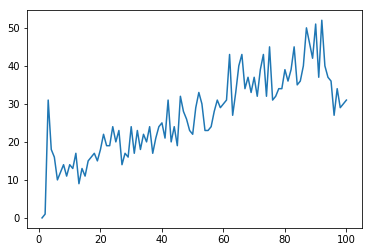

In [10]:
# Birth
plt.plot(t[:,0],t[:,2])

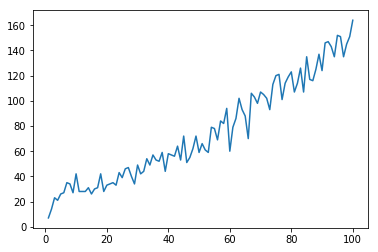

In [11]:
# Injuries
plt.plot(t[:,0],t[:,3])

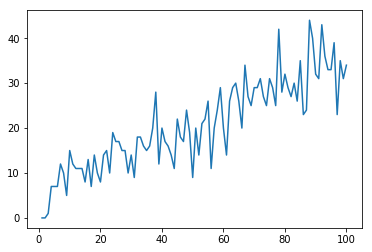

In [12]:
# Deaths
plt.plot(t[:,0],t[:,4])

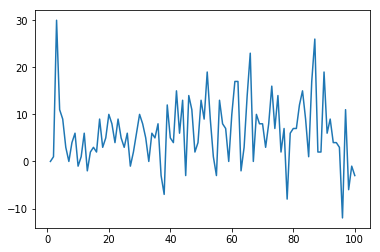

In [13]:
# Births-Deaths
plt.plot(t[:,0],t[:,2]-t[:,4])

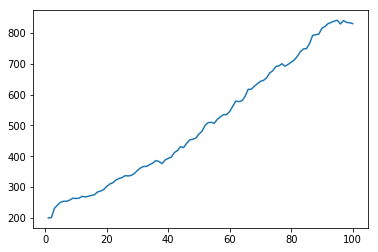

In [14]:
# Population
plt.plot(t[:,0],t[:,5])

In [15]:
# Summary
t

array([[  1,   0,   0,   7,   0, 200],
       [  2,   0,   1,  14,   0, 201],
       [  3,   2,  31,  23,   1, 231],
       [  4,   2,  18,  21,   7, 242],
       [  5,   1,  16,  26,   7, 251],
       [  6,   5,  10,  27,   7, 254],
       [  7,   6,  12,  35,  12, 254],
       [  8,  12,  14,  34,  10, 258],
       [  9,   6,  11,  27,   5, 264],
       [ 10,   6,  14,  42,  15, 263],
       [ 11,   4,  13,  28,  12, 264],
       [ 12,   6,  17,  28,  11, 270],
       [ 13,   8,   9,  28,  11, 268],
       [ 14,   5,  13,  31,  11, 270],
       [ 15,   4,  11,  26,   8, 273],
       [ 16,   8,  15,  30,  13, 275],
       [ 17,   8,  16,  31,   7, 284],
       [ 18,   5,  17,  42,  14, 287],
       [ 19,   9,  15,  28,  10, 292],
       [ 20,   9,  18,  33,   8, 302],
       [ 21,   7,  22,  34,  14, 310],
       [ 22,   8,  19,  35,  15, 314],
       [ 23,  12,  19,  33,  10, 323],
       [ 24,  11,  24,  43,  19, 328],
       [ 25,  10,  20,  39,  17, 331],
       [ 26,   9,  23,  4

In [16]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 2898\nNumber of edges: 2698\nAverage degree:   1.8620'

In [17]:
c2, cw2, db = extract_tribe(c, cw, 5, [1])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 4 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 4 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 3 0
 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 2 0 4 0 0 4 0 0 0 0 3 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 2 0 0 0 0 0 0 3 0 0 0 0 0 0 4 3 1 3 4 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 4 2 0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0 0 0 0 0 0 0
 0 0 0 4 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 4 0 0 4 0 0 2 0 0 0 1 0 0
 0 0 0 0 0 3 2 0 0 0 0 0 4 0 3 0 0 4 0 0 0 0 0 0 0 0 0 0 3 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 4 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 4 1 4
 0 1 0 2 2 0 0 0 4 0 0 0 0 0 0 0 0 4 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 2 0 0 0
 4 2 0 0 0 0 4 0 0 0 3 0 0 0 0 0 0 0 4 0 0 0 1 4 0 0 0 0 1 1 0 0 0 0 0 4 0
 4 1 0 2 0 0 0 0 1 0 0 0 1 0 2 4 0 0 0 0 1 0 1 3 0 0 2 0 0 0 4 0 0 0 0 0 0
 1 0 0 0 0 4 0 1 0 0 0 1 

In [18]:
gr2, c3, cw3, g2, t2, a2 = slime(c2, cw2, board_size=128, frames=100)

We're going extinct, make babies!  Breeding requirements decreased to 5.
We're going extinct, make babies!  Breeding requirements decreased to 4.
We're going extinct, make babies!  Breeding requirements decreased to 3.
Frame 10 took 0.2 seconds.
Frame 20 took 0.3 seconds.
Frame 30 took 0.3 seconds.
Frame 40 took 0.4 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 4.
Too crowded, stop having kids!  Breeding requirements increased to 5.
Too crowded, stop having kids!  Breeding requirements increased to 6.
Frame 50 took 0.4 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 7.
Too crowded, stop having kids!  Breeding requirements increased to 8.
Too crowded, stop having kids!  Breeding requirements increased to 9.
Too crowded, stop having kids!  Breeding requirements increased to 10.
Frame 60 took 0.5 seconds.
Frame 70 took 0.4 seconds.
Too crowded, stop having kids!  Breeding requirements increased to 11.
Too crowded, stop having kids!

Too crowded, stop having kids!  Breeding requirements increased to 18.
Frame 100 took 0.4 seconds.


Total Run Time:  41.9 seconds.



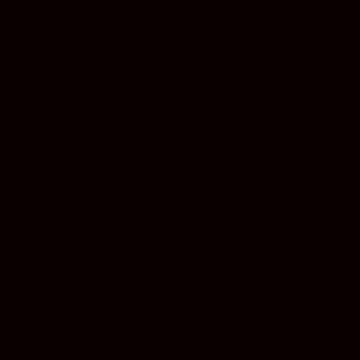
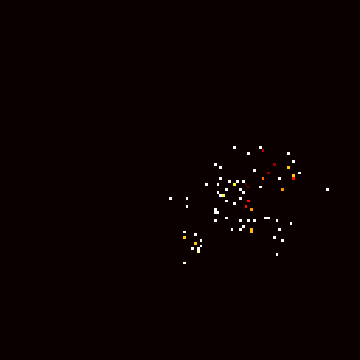
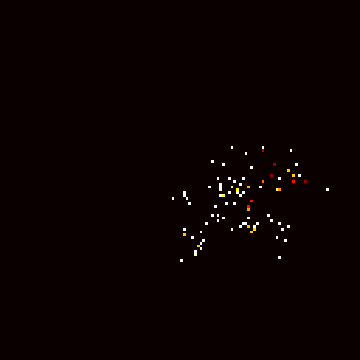
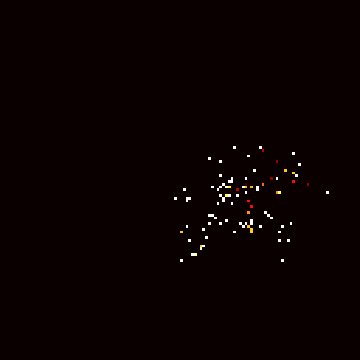
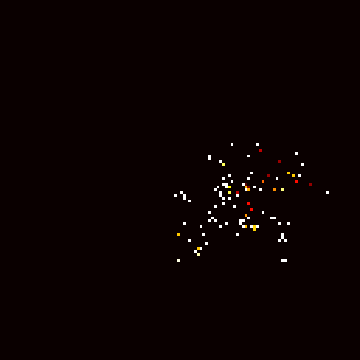
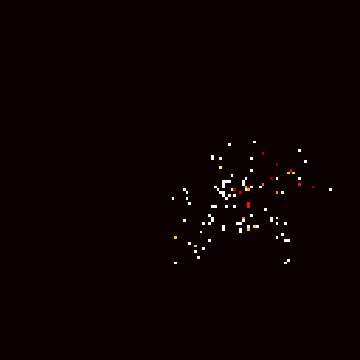
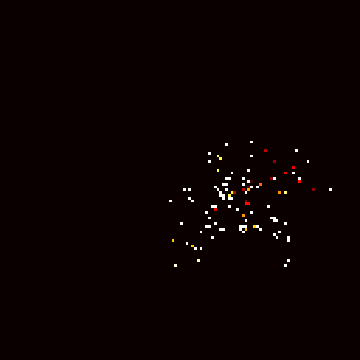
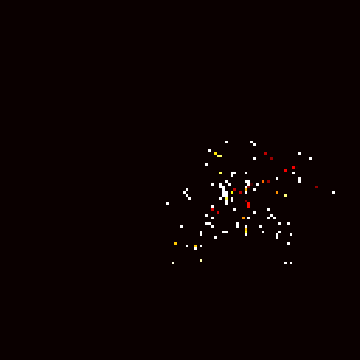
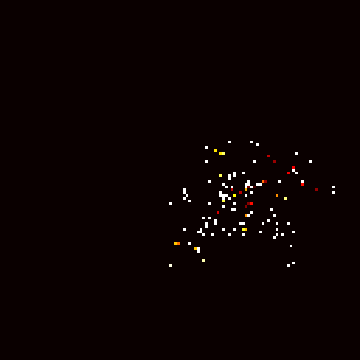
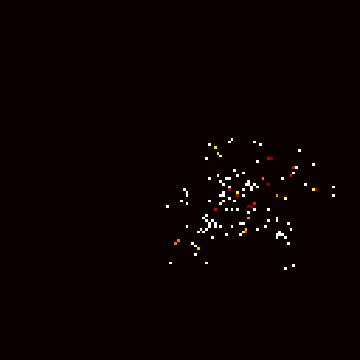
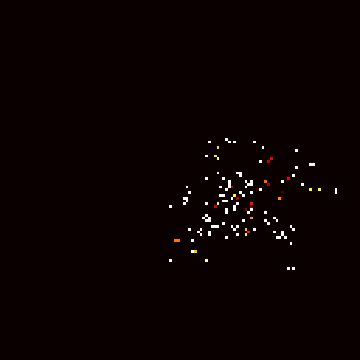
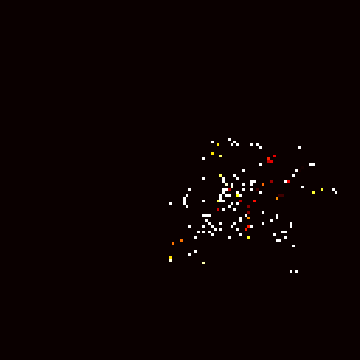
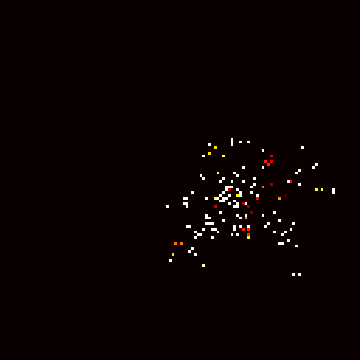
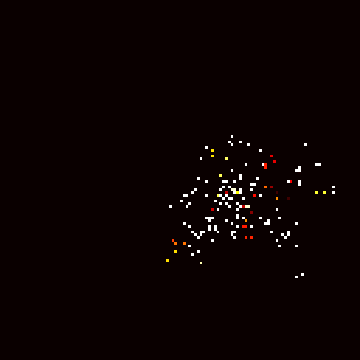
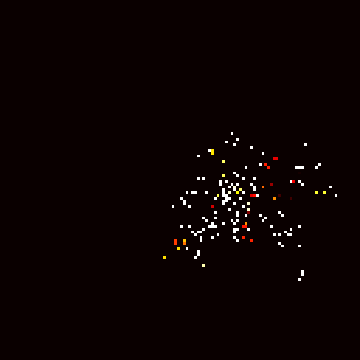
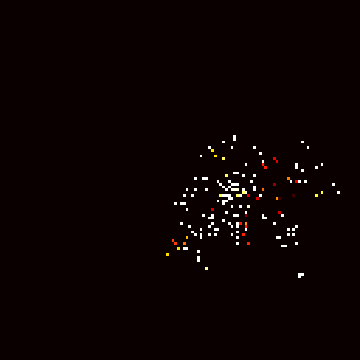
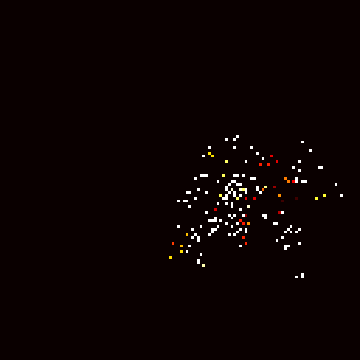
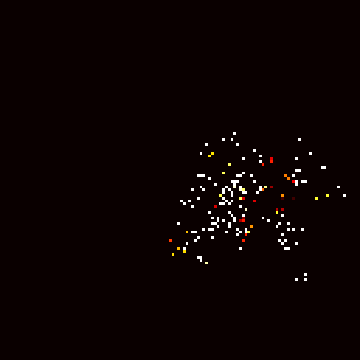
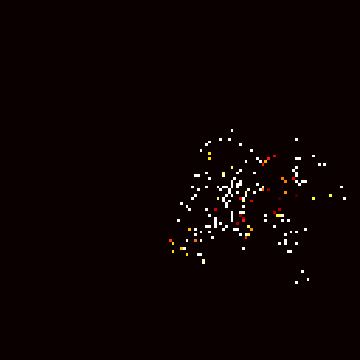
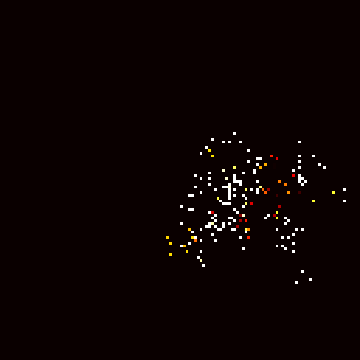
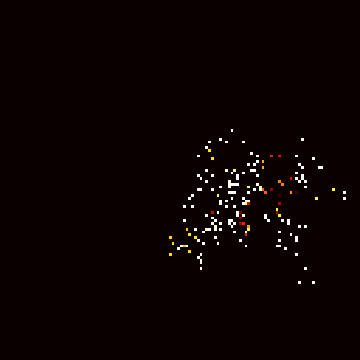
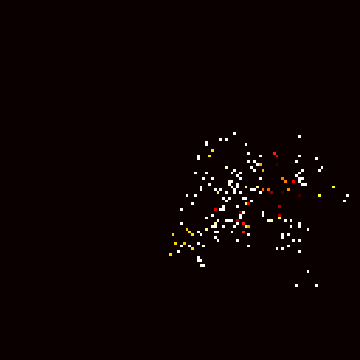
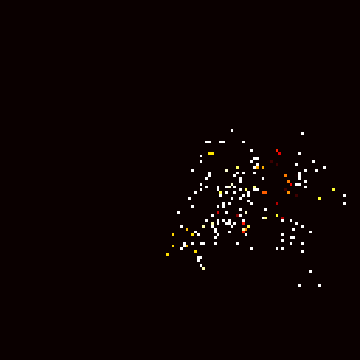
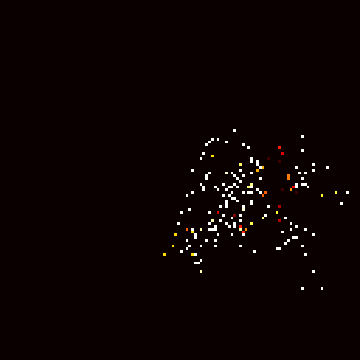
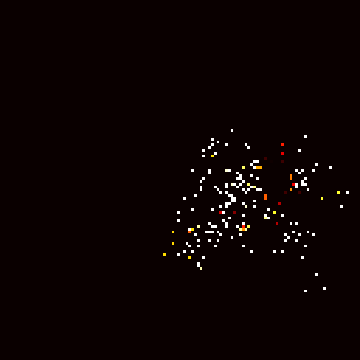
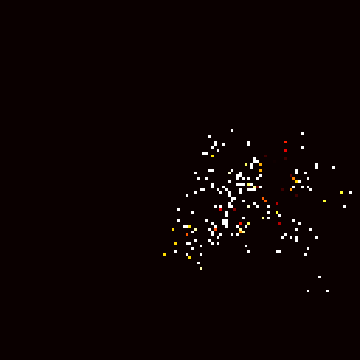
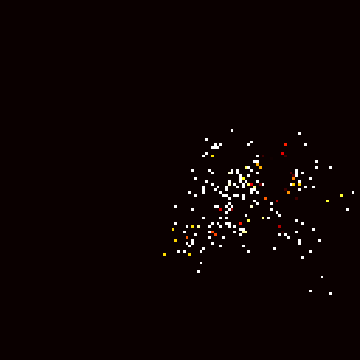
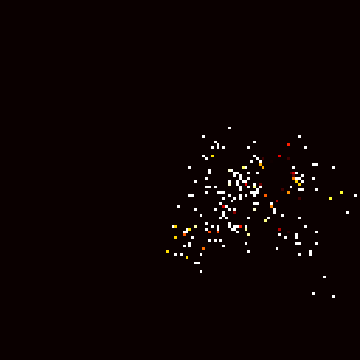
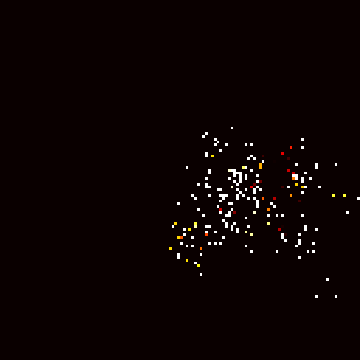
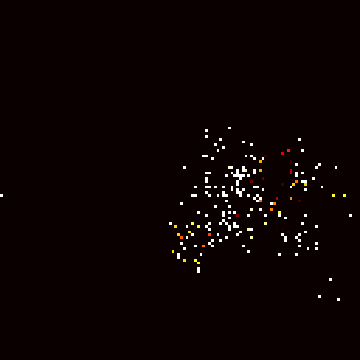
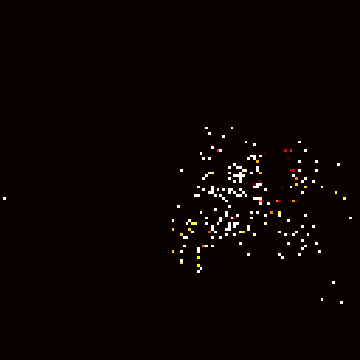
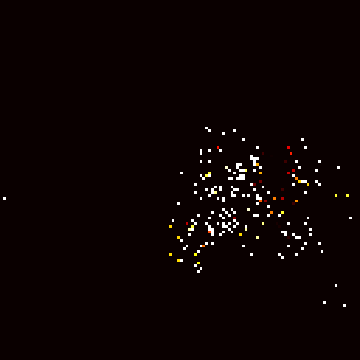
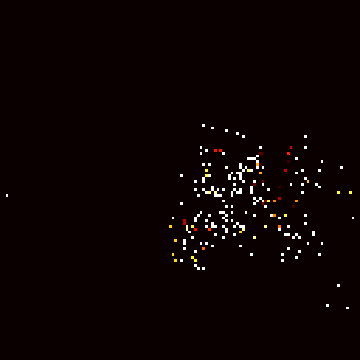
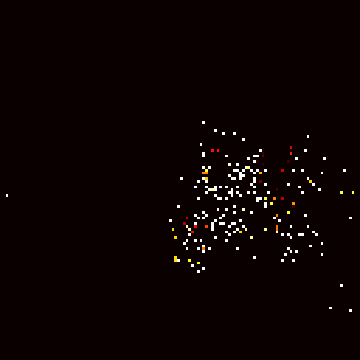
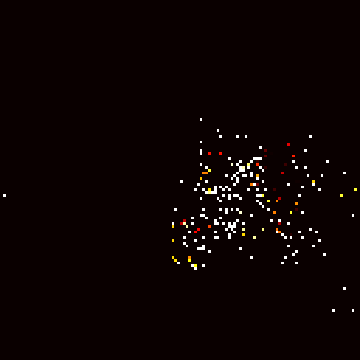
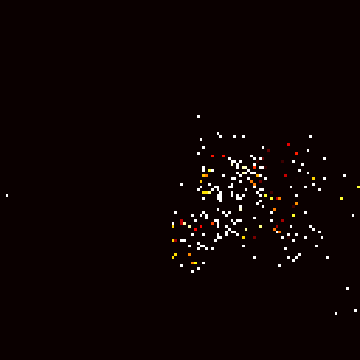
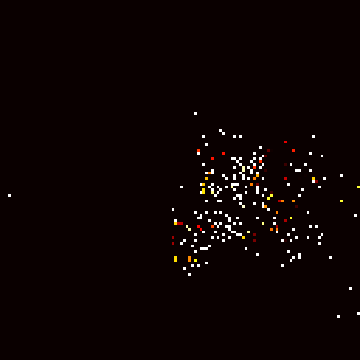
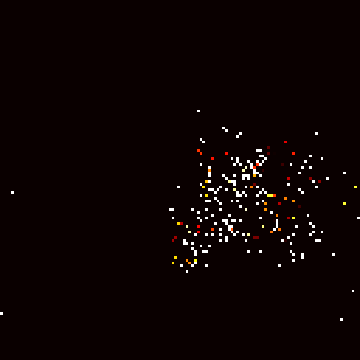
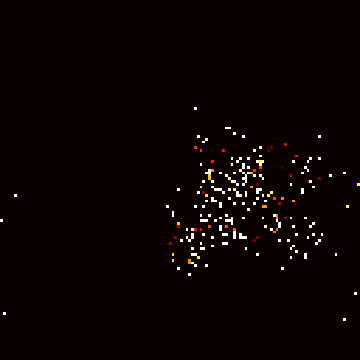
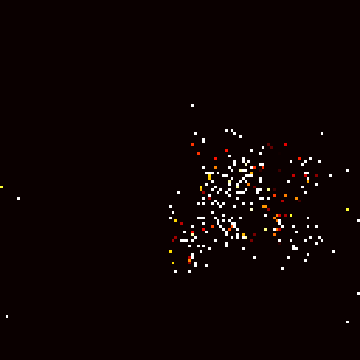
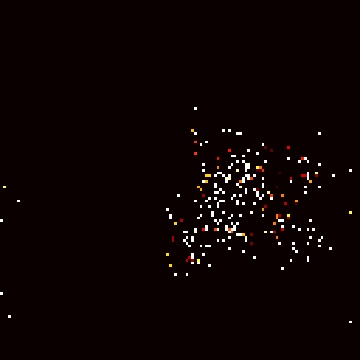
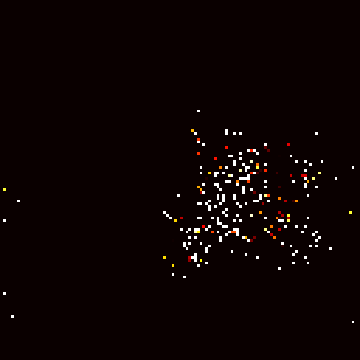
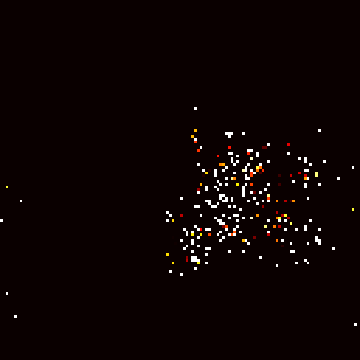
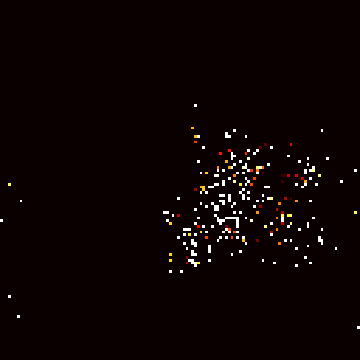
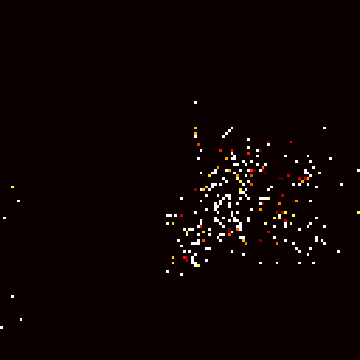
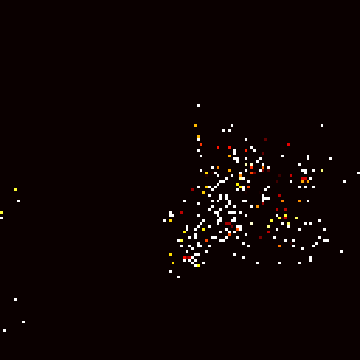
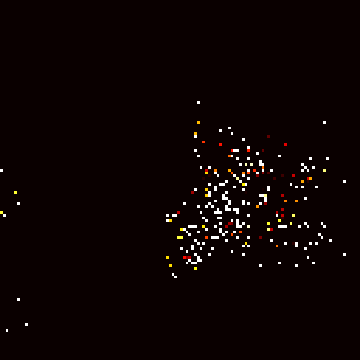
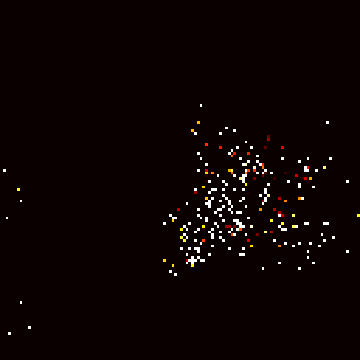
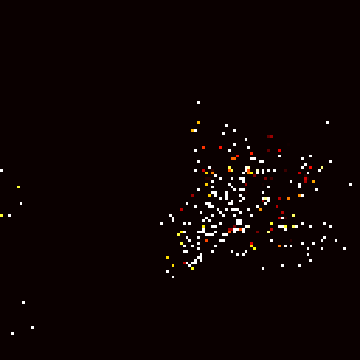
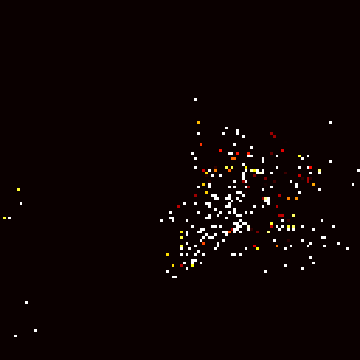
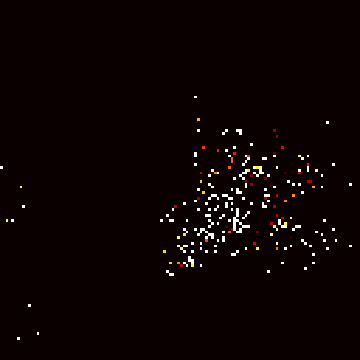
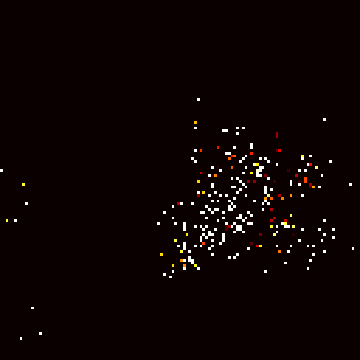
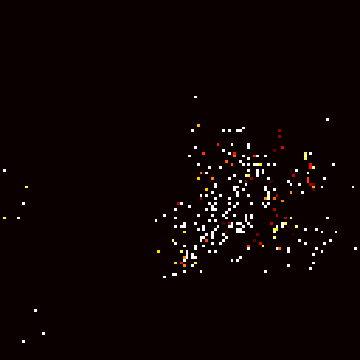
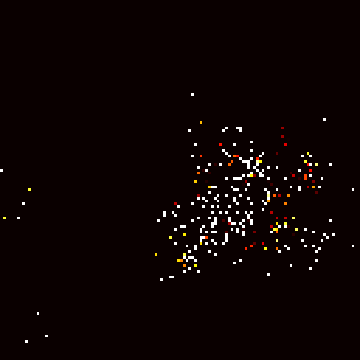
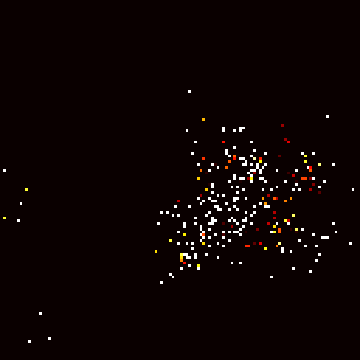
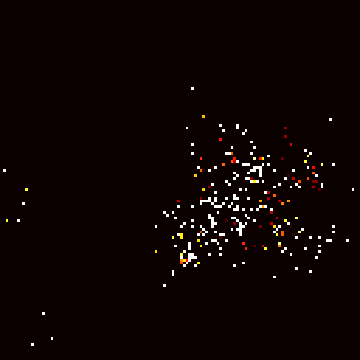
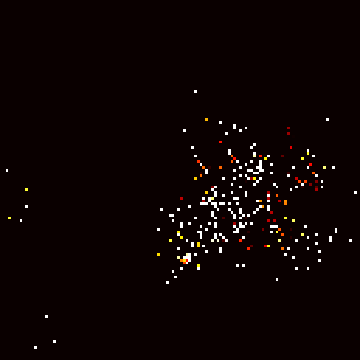
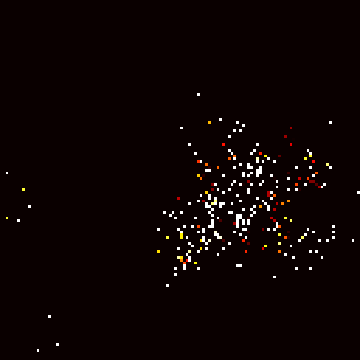
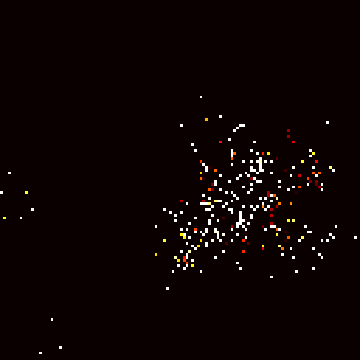
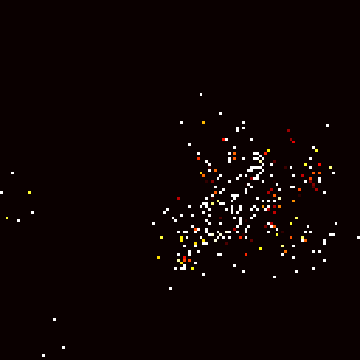
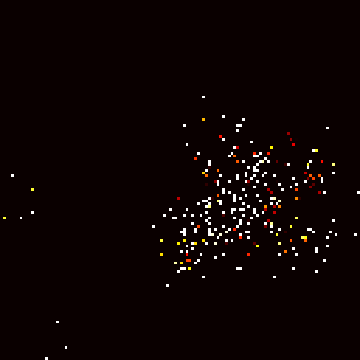
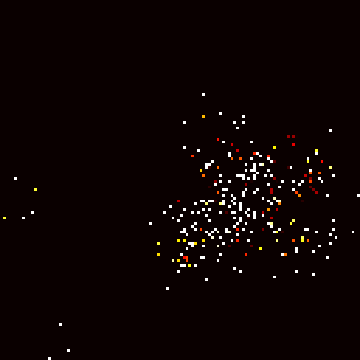
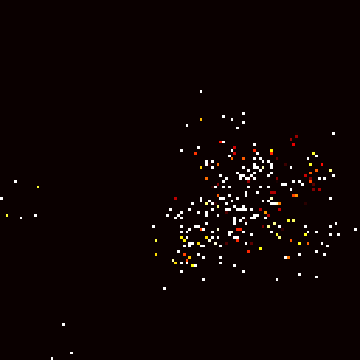
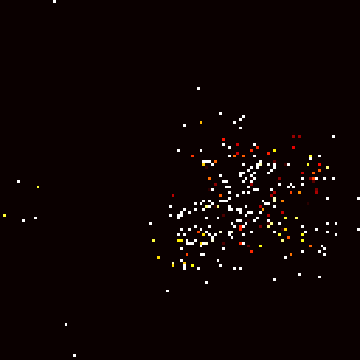
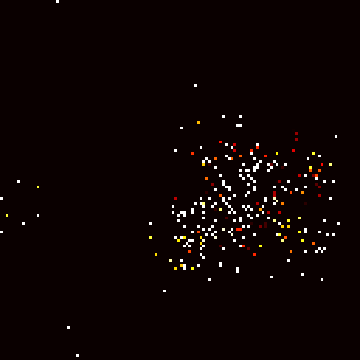
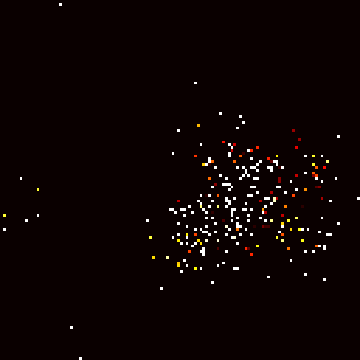
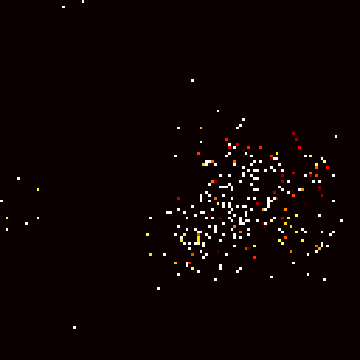
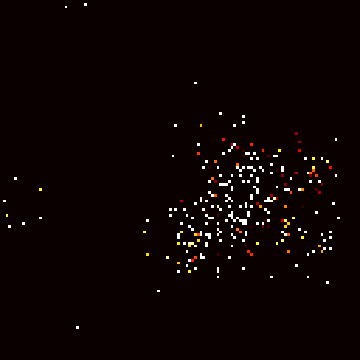
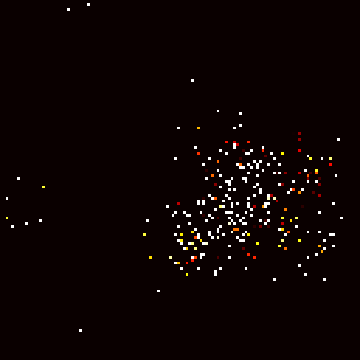
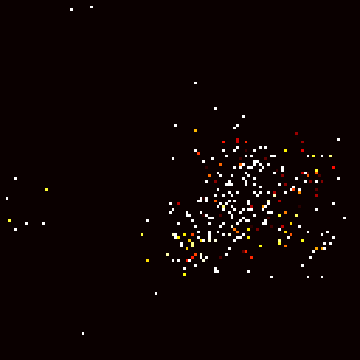
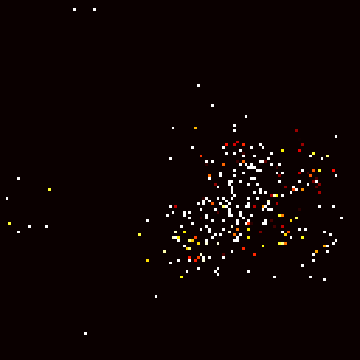
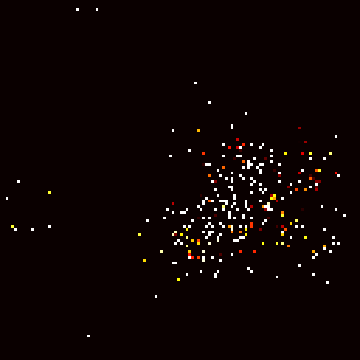
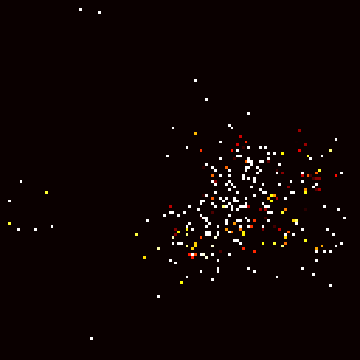
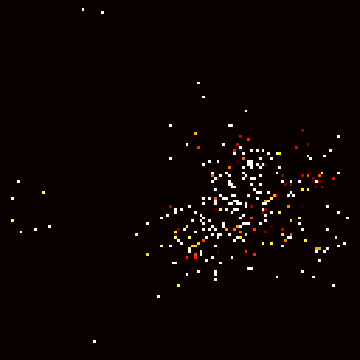
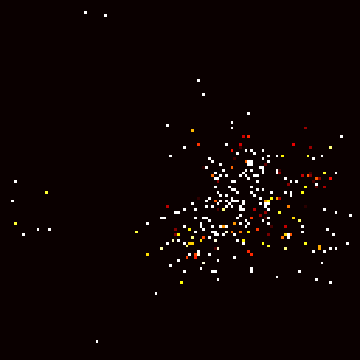
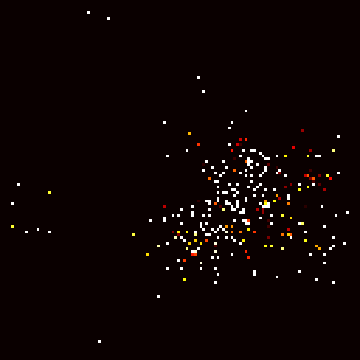
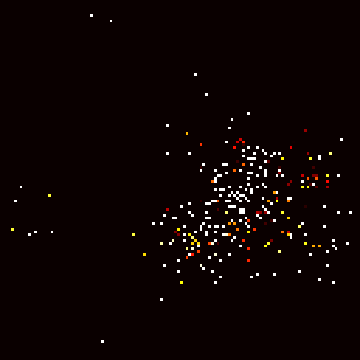
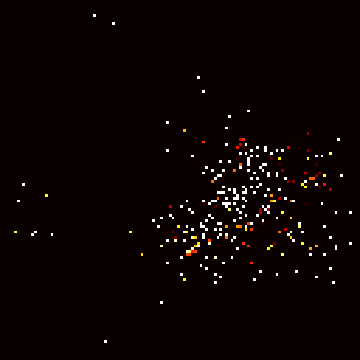
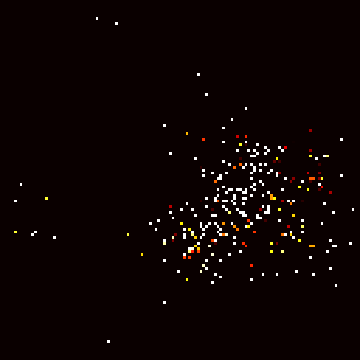
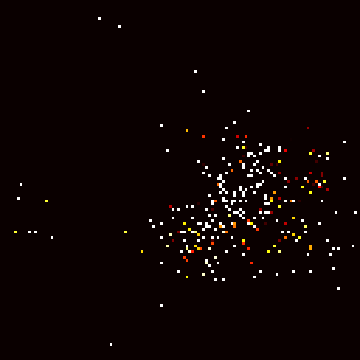
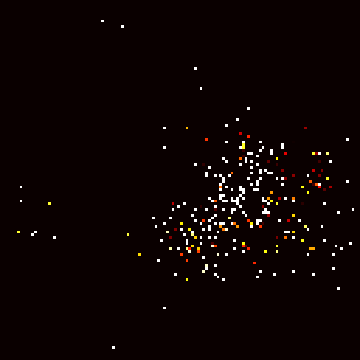
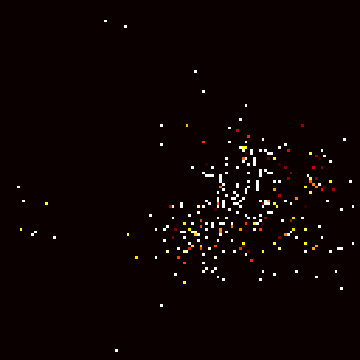
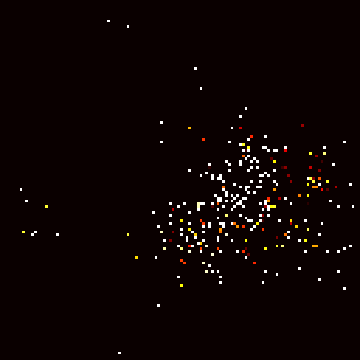
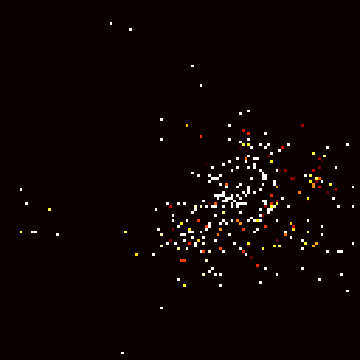
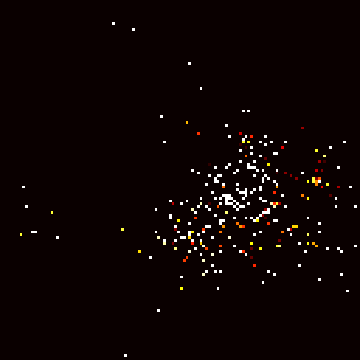
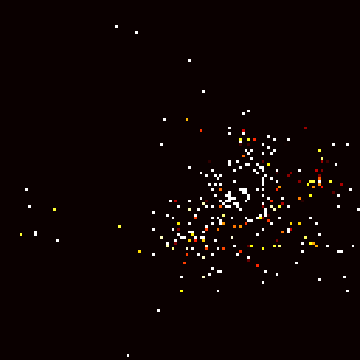
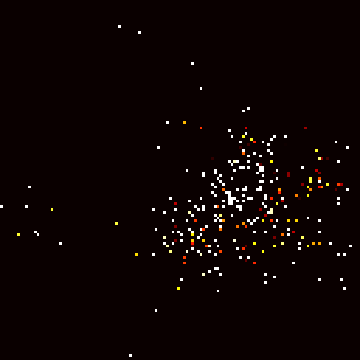
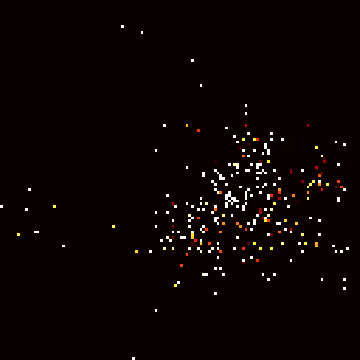
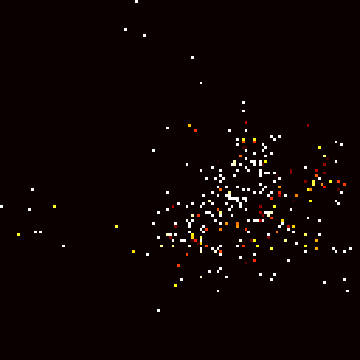
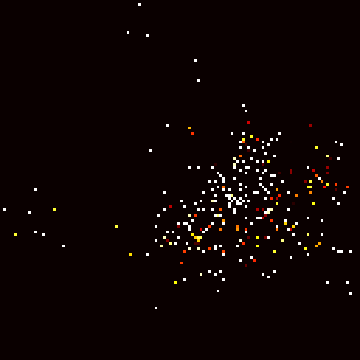
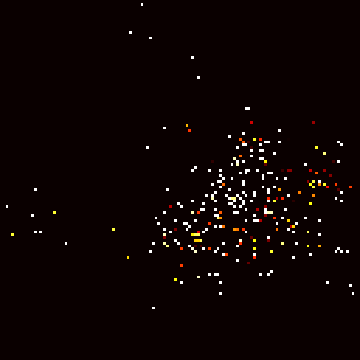
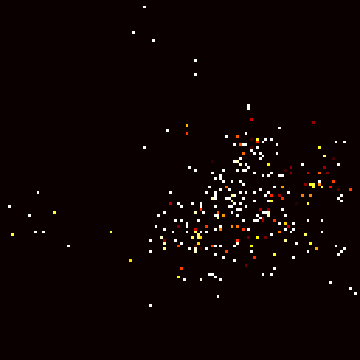
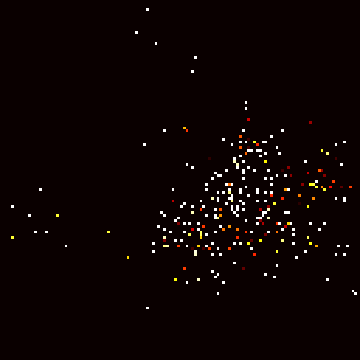
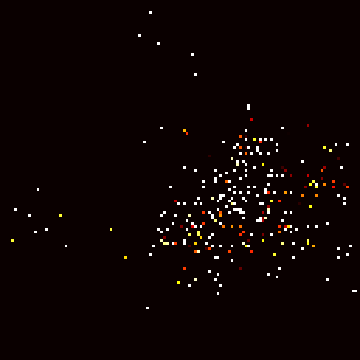
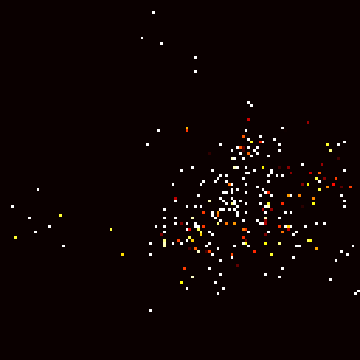
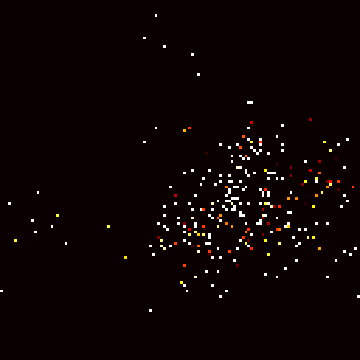
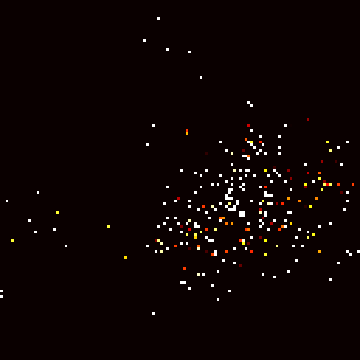
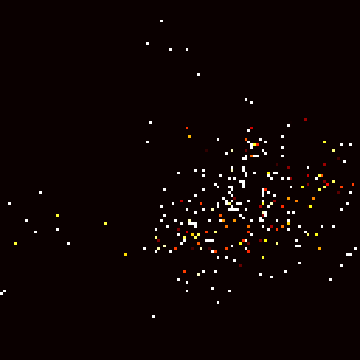
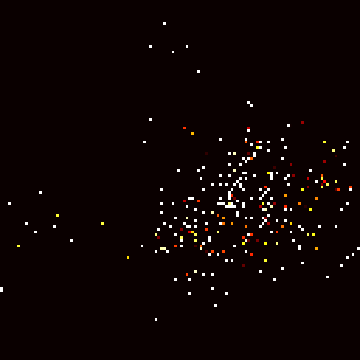
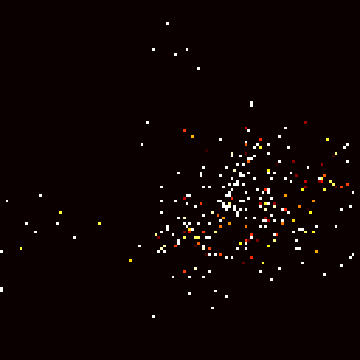

In [19]:
gr2

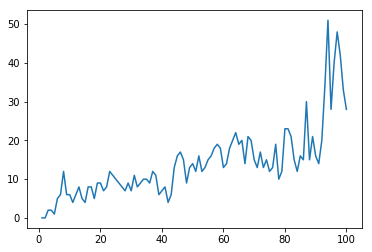

In [20]:
# Growth
plt.plot(t2[:,0],t[:,1])

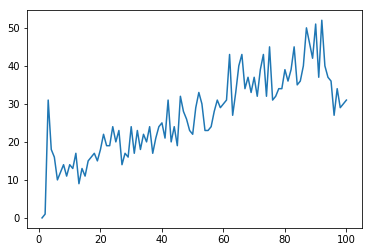

In [21]:
# Birth
plt.plot(t2[:,0],t[:,2])

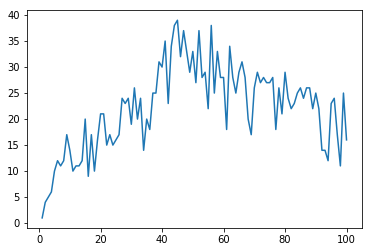

In [22]:
# Injuries
plt.plot(t2[:,0],t2[:,3])

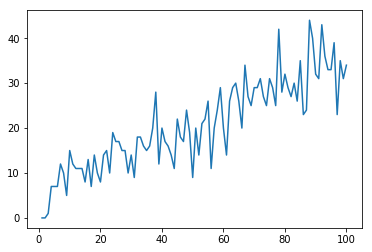

In [23]:
# Deaths
plt.plot(t2[:,0],t[:,4])

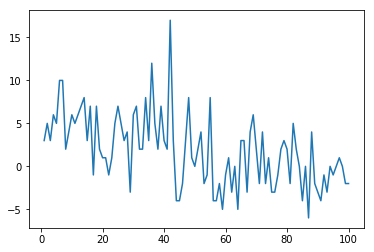

In [24]:
# Births-Deaths
plt.plot(t2[:,0],t2[:,2]-t2[:,4])

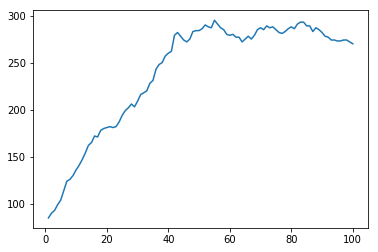

In [25]:
# Population
plt.plot(t2[:,0],t2[:,5])

In [26]:
# Summary
t2

array([[  1,   1,   3,   1,   0,  85],
       [  2,   3,   5,   4,   0,  90],
       [  3,   0,   4,   5,   1,  93],
       [  4,   3,   6,   6,   0,  99],
       [  5,   1,   7,  10,   2, 104],
       [  6,   4,  11,  12,   1, 114],
       [  7,   0,  12,  11,   2, 124],
       [  8,   6,   7,  12,   5, 126],
       [  9,   6,  10,  17,   6, 130],
       [ 10,   3,  10,  14,   4, 136],
       [ 11,   2,   6,  10,   1, 141],
       [ 12,   9,   9,  11,   3, 147],
       [ 13,   4,  10,  11,   3, 154],
       [ 14,   2,  12,  12,   4, 162],
       [ 15,   9,   6,  20,   3, 165],
       [ 16,   8,  12,   9,   5, 172],
       [ 17,   5,   5,  17,   6, 171],
       [ 18,   4,  10,  10,   3, 178],
       [ 19,   8,   7,  16,   5, 180],
       [ 20,   8,   9,  21,   8, 181],
       [ 21,   5,   6,  21,   5, 182],
       [ 22,   7,   6,  15,   7, 181],
       [ 23,   5,   7,  17,   6, 182],
       [ 24,   6,   9,  15,   4, 187],
       [ 25,   8,  14,  16,   7, 194],
       [ 26,   5,  10,  1

In [27]:
nx.info(g2)

'Name: \nType: Graph\nNumber of nodes: 747\nNumber of edges: 747\nAverage degree:   2.0000'

In [28]:
#import dill
#dill.dump_session('notebook_env.db')

In [29]:
#import dill
#dill.load_session('notebook_env.db')